# Problema a ser resolvido:

------

- Tenho uma carteira com 5 ações. Dado a distribuição dos retornos dessa carteira no último ano:

    * Qual o máximo que eu posso perder no próximo ano, com uma confiança de 95%?
    * Qual a probabilidade de eu obter lucro?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from numpy import linalg as LA

In [2]:
#pegando dados

lista_acoes = ['WEGE3', 'PCAR3', 'LREN3', 'PETR4', 'VALE3']
lista_acoes = [acao + ".SA" for acao in lista_acoes]

data_final = dt.datetime.now()
data_inicial = data_final - dt.timedelta(days=300)

precos = yf.download(lista_acoes, data_inicial, data_final)['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [74]:
#calculando retornos pegando matriz de covariância 

retornos = precos.pct_change().dropna()
media_retornos = retornos.mean()
matriz_covariancia = retornos.cov()
pesos_carteira = np.full(len(lista_acoes), 1/len(lista_acoes))
numero_acoes = len(lista_acoes)



# Fórmula retornos sintéticos
---
Retornos_sintéticos = média_retornos + Rpdf × L.

* média_retornos = Média dos retornos.
* Rpdf = Matriz aleatória gerada por alguma função de densidade de probabilidade.
* L = Matriz triangular inferior proveniente de uma decomposição de Cholesky, usando como base a matriz de covariância dos dados originais.


In [4]:
#premissas montecarlo

numero_simulacoes = 10000
dias_projetados = 252 
capital_inicial = 1000

In [5]:
#gerando retorno médio

retorno_medio = retornos.mean(axis = 0).to_numpy() 
matriz_retorno_medio = retorno_medio * np.ones(shape = (dias_projetados, numero_acoes))

In [ ]:
#gerando L

L = LA.cholesky(matriz_covariancia)

In [9]:
#gerando simulações

retornos_carteira = np.zeros([dias_projetados, numero_simulacoes]) #cada coluna é uma simulação
montante_final = np.zeros(numero_simulacoes)

for s in range(numero_simulacoes):

    Rpdf = np.random.normal(size=(dias_projetados, numero_acoes)) 
    
    retornos_sintéticos = matriz_retorno_medio + np.inner(Rpdf, L) 
    
    retornos_carteira[:, s] = np.cumprod(np.inner(pesos_carteira, 
                                                  retornos_sintéticos) + 1) * capital_inicial
    montante_final[s] = retornos_carteira[-1, s]
    
    
retornos_carteira

array([[1000.16715419,  999.47982369,  996.91405462, ...,  989.76640784,
         997.47010237,  986.30984278],
       [ 996.87554244,  997.00874967,  988.80270243, ..., 1005.77096507,
        1020.42190212,  986.89518145],
       [1026.15941147, 1001.56626753,  981.65746709, ...,  974.86438249,
        1033.50202067, 1013.27942745],
       ...,
       [1129.48515262,  747.26193937,  601.64408346, ...,  798.82874877,
         514.75105361,  701.48881122],
       [1130.20987284,  757.70660034,  595.80637109, ...,  801.12799589,
         504.82150076,  701.85624475],
       [1145.21143913,  750.44466979,  596.9699182 , ...,  775.569876  ,
         499.49596032,  689.14899652]])

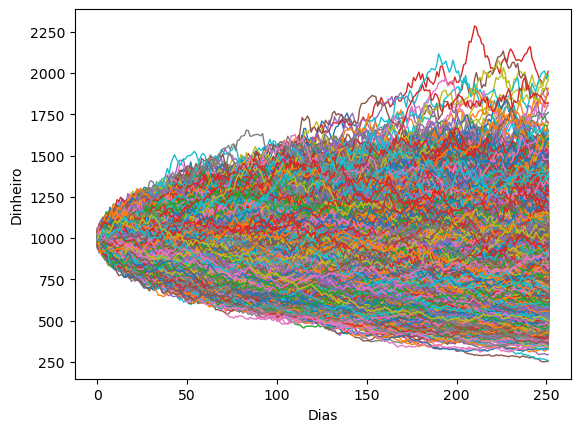

In [12]:
plt.plot(retornos_carteira, linewidth=1)
plt.ylabel('Dinheiro')
plt.xlabel('Dias')
plt.show()

In [13]:
montante_99 = str(np.percentile(montante_final, 1))
montante_95 = str(np.percentile(montante_final, 5))
montante_mediano = str(np.percentile(montante_final, 50))
cenarios_com_lucro = str((len(montante_final[montante_final > 1000])/
                                len(montante_final)) * 100) + "%"

In [58]:
print(f'''Ao investir R$ {capital_inicial},00 

Carteira: {lista_acoes} 

Podemos esperar esses resultados para os próximo ano, utilizando o método de Monte Carlo com 10 mil simulações:

Com 50% de probabilidade, o montante será maior que R$ {montante_mediano}. 

Com 95% de probabilidade, o montante será maior que R$ {montante_95}.

Com 99% de probabilidade, o montante será maior que R$ {montante_99}.

Em {cenarios_com_lucro} dos cenários, foi possível obter lucro no próximo ano.''')

Ao investir R$ 1000,00 

Carteira: ['WEGE3.SA', 'PCAR3.SA', 'LREN3.SA', 'PETR4.SA', 'VALE3.SA'] 

Podemos esperar esses resultados para os próximo ano, utilizando o método de Monte Carlo com 10 mil simulações:

Com 50% de probabilidade, o montante será maior que R$ 776.4558031890826. 

Com 95% de probabilidade, o montante será maior que R$ 503.5100711297517.

Com 99% de probabilidade, o montante será maior que R$ 423.7921873460794.

Em 16.72% dos cenários, foi possível obter lucro no próximo ano.


In [62]:
var_95 = '{:.2f}%'.format(((float(montante_95)/capital_inicial)-1)*100)


print(f'''Utilidades:

A partir dessas métricas, é possível calcular coisas como o VAR da carteira para diferentes intervalos de confiança e medir se o risco que você está correndo é compatível com o que você aguenta perder. 

No caso dessa carteira, uma queda de {var_95} está dentro dos 95% dos cenários possíveis de acontecer no próximo ano.''') 

Utilidades:

A partir dessas métricas, é possível calcular coisas como o VAR da carteira para diferentes intervalos de confiança e medir se o risco que você está correndo é compatível com o que você aguenta perder. 

No caso dessa carteira, uma queda de -49.65% está dentro dos 95% dos cenários possíveis de acontecer no próximo ano.


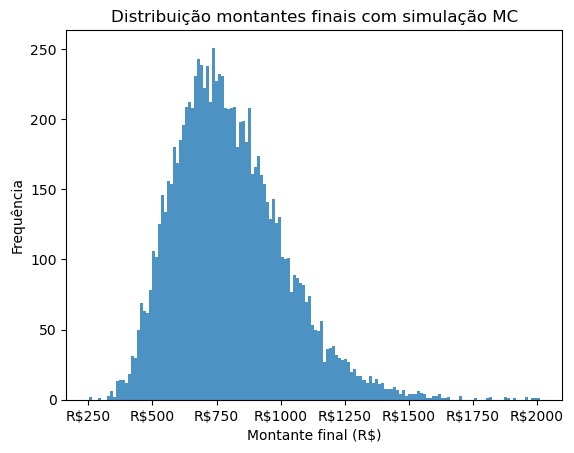

In [33]:
config = dict(histtype = "stepfilled", alpha = 0.8, density = False, bins = 150)
fig, ax = plt.subplots()
ax.hist(montante_final, **config)
ax.xaxis.set_major_formatter('R${x:.0f}')
plt.title('Distribuição montantes finais com simulação MC')
plt.xlabel('Montante final (R$)')
plt.ylabel("Frequência")
plt.show()